<a href="https://colab.research.google.com/github/cristobalvch/DataScience-For-Business/blob/main/Sales-Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TAREA #1: ENTENDER EL ENUNCIADO DEL PROBLEMA Y EL CASO PRÁCTICO


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=1l7bHyrjzq839zVZE06cfdDksLabCN2hg"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figura 1. Prediccion de Ventas Futuras usando Series Temporales
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=179967pYtO8DZkFIiqkzKeDXpzKF13KE9)

![alt text](https://drive.google.com/uc?id=1MHVbje9FNlAbo-LOMlCvSYfpgzW7PQ4y)

![alt text](https://drive.google.com/uc?id=1DC-hoQNAxfDXEn91_BTF2B8qH904N8yq)

![alt text](https://drive.google.com/uc?id=1sM7eT88kpVmNMl7wJy0Jq0X_w-r783JF)

![alt text](https://drive.google.com/uc?id=1E6qCyK6SjFany6QsXw8lUc77CSOgjTkj)

# TAREA #2: IMPORTAR LAS LIBRERÍAS Y LOS DATASETS

In [1]:
!pip install fbprophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from fbprophet import Prophet

TAREA #2.1: IMPORTAR EL DATASET DE VENTAS

In [3]:
# Debes incluir el enlace completo al archivo csv que contiene tu conjunto de datos
sales_df = pd.read_csv('https://raw.githubusercontent.com/joanby/ds4b/main/3.%20Sales%20Department%20Data/train.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
sales_df.head(5)
# Casi un millón de observaciones
# 1115 tiendas únicas 
# Notemos que las ventas es la variable objetivo (la que intentamos predecir)

# Id:  ID de transacción (combinación de la tienda y la fecha)
# Store: identificador único de la tienda
# Sales: ventas diarias, esta es la variable objetivo
# Customers: número de clientes de un día dado
# Open: Booleano para indicar si la tienda estaba abierta o cerrada (0 = cerrada, 1 = abierta)
# Promo: describe si la tienda tenía algún tipo de promoción ese día o no
# StateHoliday: indica si el día era festivo o no (a = vacaciones públicas, b = vacaciones de Pascua holiday, c = Navidades, 0 = No era festivo)
# SchoolHoliday: indica si (Store, Date) se ve afectado por el cierre de las escuelas públicas
# Fuente original de los datos: https://www.kaggle.com/c/rossmann-store-sales/data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
# 9 columnas en total 
# 8 características, cada una con 1017209 puntos de datos
# 1 variable objetivo (ventas)
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
# Cantidad de ventas promedio por día = 5773 Euros, ventas mínimas por día = 0, ventas máximas por día = 41551
# Número medio de clientes = 633, número mínimo de clientes = 0, número máximo de clientes = 7388
sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


TAREA #2.2: IMPORTAR LA INFORMACIÓN SOBRE LAS TIENDAS



In [7]:
store_df = pd.read_csv('https://raw.githubusercontent.com/joanby/ds4b/main/3.%20Sales%20Department%20Data/store.csv')
# StoreType: categoría que indica el tipo de tienda (a, b, c, d)
# Assortment:  a = básico, b = extra, c = extedido
# CompetitionDistance (en metros): distancia a la tienda de la competencia más cercana
# CompetitionOpenSince [Mes/Año]:  fecha en que abrió la competencia
# Promo2: Promo2 es una promoción continuada y consecutiva en algunas tiendas (0 = la tienda no participa, 1 = la tienda participa)
# Promo2Since [Año/Semana]: fecha en la que la tienda empieza a participar en la Promo2
# PromoInterval: describe los intervalos consecutivos donde la Promo2 empieza, indicando los meses en los que empieza la misma. P.e. "Feb,May,Aug,Nov" significa que cada nueva ronda de promoción empieza en Febrero, Mayo, Agosto, Noviembre de cualquier año de esa tienda


In [8]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
# Hagamos lo mismo con los datos store_info_df
# Hay que tener en cuenta que el data frame anterior incluye las transacciones registradas por día (en millones)
# Este data frame solo incluye información sobre las 1115 tiendas exclusivas que forman parte de este estudio
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [10]:
# De media, la distancia de la competencia es de 5404 metros (5,4 kms)
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


# TAREA #3: EXPLORAR EL DATASET

TAREA #3.1: EXPLORAR EL DATASET DE VENTAS

NaN of Sales Data: 
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


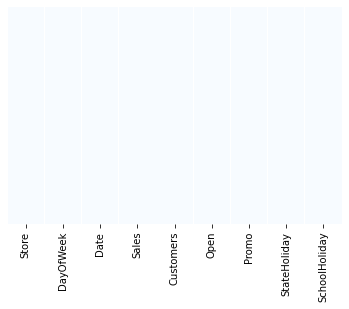

In [11]:
# Veamos si nos faltan datos, ¡esperemos que no sea así!
print(f"NaN of Sales Data: \n{sales_df.isnull().sum()}")
sns.heatmap(sales_df.isnull(),yticklabels=False,cbar=False,cmap='Blues')

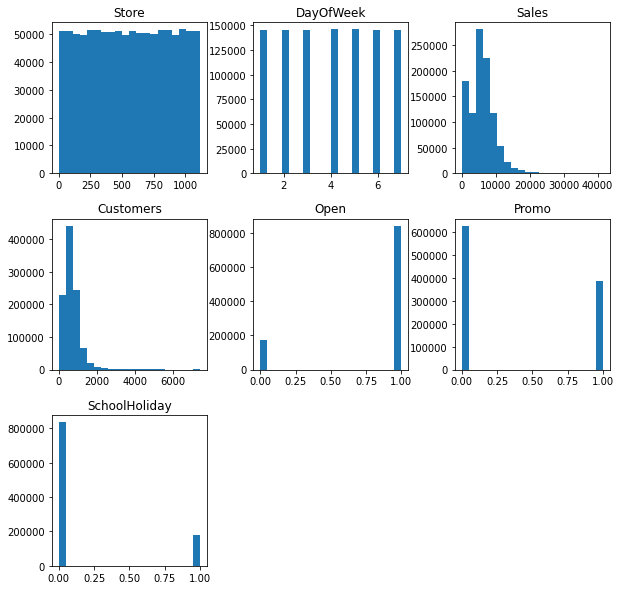

In [12]:
# Promedio de 600 clientes por día, el máximo es 4500 (¡tenga en cuenta que no podemos ver el valor atípico en 7388!)
# Los datos se distribuyen por igual en varios días de la semana (~ 150000 observaciones x 7 días = ~ 1,1 millones de observaciones)
# Las tiendas están abiertas ~ 80% del tiempo
# Los datos se distribuyen por igual entre todas las tiendas (sin sesgo)
# La promoción # 1 se ejecutó aproximadamente el 40% del tiempo
# Ventas promedio alrededor de 5000-6000 Euros
# Las vacaciones escolares duran alrededor del 18% del tiempo
sales_df.hist(bins=20,figsize=(10,10),grid=False)
plt.show()

In [13]:
# ¡Veamos cuántas tiendas están abiertas y cerradas!
open_stores = sales_df[sales_df['Open'].isin([1])]
close_stores = sales_df[sales_df['Open'].isin([0])]

In [14]:
# Contemos el número de tiendas que están abiertas y cerradas
print("Numero de tiendas abiertas: {}".format(len(open_stores)))
print("Numero de tiendas cerradas: {}".format(len(close_stores)))
print("Porcentaje de tiendas cerradas: {}".format(100*len(close_stores)/len(sales_df)))

Numero de tiendas abiertas: 844392
Numero de tiendas cerradas: 172817
Porcentaje de tiendas cerradas: 16.98933060954042


In [15]:
# Eliminemos la columna open ya que ahora no tiene sentido
open_stores.drop(['Open'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# Ventas promedio = 6955 Euros, número promedio de clientes = 762 (ha subido)
open_stores.reset_index(drop=True,inplace=True)
print("Promedio de Venta en tiendas abiertas: {}".format(round(open_stores.Sales.mean())))
print("Promedio de Clientes en tiendas abiertas: {}".format(round(open_stores.Customers.mean())))

Promedio de Venta en tiendas abiertas: 6956
Promedio de Clientes en tiendas abiertas: 763


In [17]:
sales_df = open_stores

TAREA #3.2: EXPLORAR LOS DATOS DE LA INFORMACIÓN DE LAS TIENDAS

NaN of Stores Data: 
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


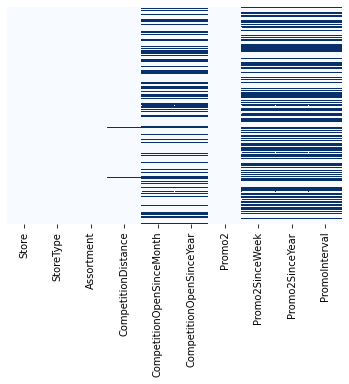

In [18]:
print(f"NaN of Stores Data: \n{store_df.isnull().sum()}")
sns.heatmap(store_df.isnull(),yticklabels=False,cbar=False,cmap='Blues')

In [19]:
# Echemos un vistazo a los valores faltantes en la 'CompetitionDistance'
# Solo faltan 3 filas
store_df[store_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [20]:
# Echemos un vistazo a los valores faltantes en el 'CompetitionOpenSinceMonth'
# Faltan muchas filas = 354 (casi un tercio de las 1115 tiendas)
store_df[store_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [21]:
# Parece que si 'promo2' es cero, 'promo2SinceWeek', 'Promo2SinceYear' y la información de 'PromoInterval' se establece en cero
# Hay 354 filas donde 'CompetitionOpenSinceYear' y 'CompetitionOpenSinceMonth' falta
# Establezcamos estos valores en ceros
store_df[store_df['Promo2'].isin([0])]
store_df['Promo2SinceWeek'].fillna(0,inplace=True)
store_df['Promo2SinceYear'].fillna(0,inplace=True)
store_df['PromoInterval'].fillna(0,inplace=True)
store_df['CompetitionOpenSinceYear'].fillna(0,inplace=True)
store_df['CompetitionOpenSinceMonth'].fillna(0,inplace=True)

In [22]:
# Hay 3 filas con valores de 'CompetitionDistance' que faltan, llenémoslas con valores promedio de la columna 'CompetitionDistance'
store_df['CompetitionDistance'].fillna(store_df.CompetitionDistance.mean(),inplace=True)

In [23]:
# la mitad de las tiendas participan en la promoción 2
# la mitad de las tiendas tienen su competencia a una distancia de 0-3000 m (3 kms de distancia)
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5404.901079,4.930942,1370.939013,0.512108,12.083408,1030.239462
std,322.01708,7652.849306,4.284924,935.467654,0.500078,15.542241,1006.038782
min,1.00000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.50000,720.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.00000,2330.000000,4.000000,2006.000000,1.000000,1.000000,2009.000000
75%,836.50000,6875.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


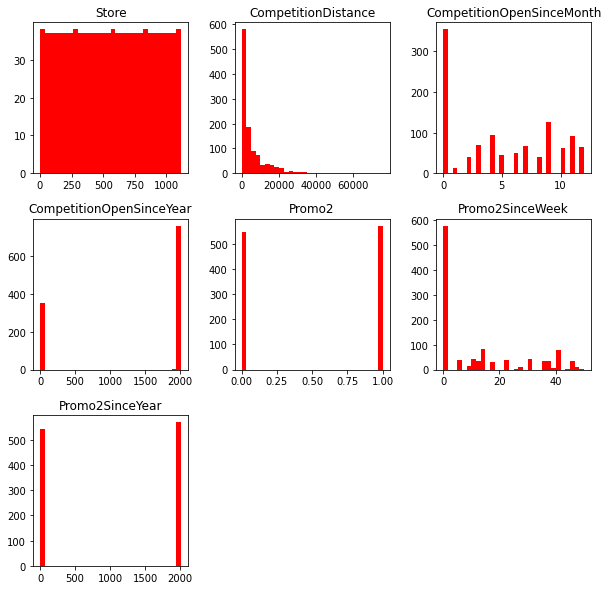

In [24]:
store_df.hist(bins=30,figsize=(10,10),color='r',grid=False)
plt.show()

TAREA #3.3: EXPLOREMOS EL DATASET COMBINADO

In [25]:
# Combinemos ambos data frames en función de 'store'
df = pd.merge(sales_df,store_df,how= 'inner',on='Store')

In [26]:
correlations = df.corr()
correlations['Sales'].sort_values()
# los clientes y la promoción se correlacionan positivamente con las ventas
# Promo2 no parece ser efectivo en absoluto

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

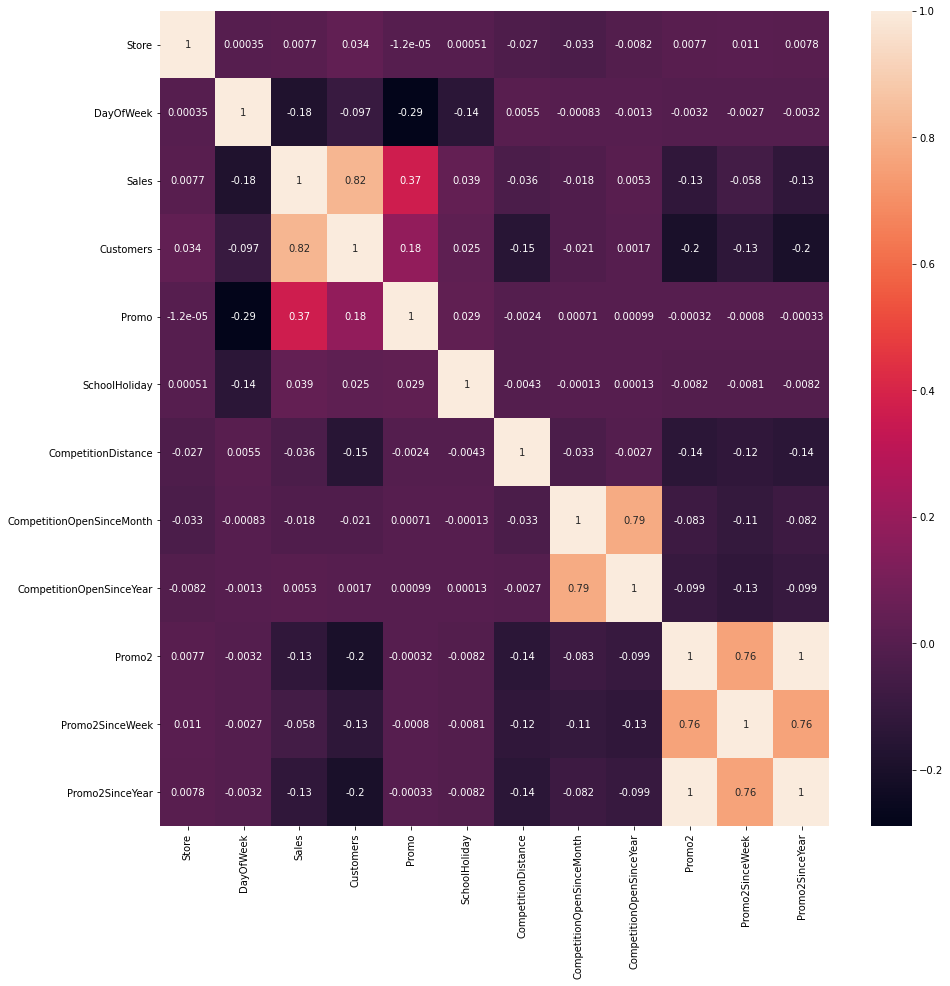

In [27]:
fig = plt.subplots(figsize=(15,15))
sns.heatmap(correlations,annot=True)
plt.show()
# Los clientes / Promo2 y las ventas están fuertemente correlacionados

In [28]:
# Separemos el año y pongámoslo en una columna separada
# Hagamos lo mismo para el día y el mes
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Day'] = pd.DatetimeIndex(df['Date']).day
df['Month'] = pd.DatetimeIndex(df['Date']).month

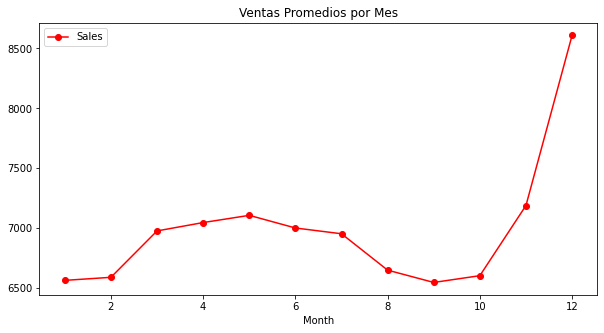

In [29]:
# Echemos un vistazo a las ventas promedio y la cantidad de clientes por mes.
# 'groupby' funciona muy bien al agrupar todos los datos que comparten la misma columna del mes, luego obtener la media de la columna de ventas
# Parece que las ventas y el número de clientes alcanzan su punto máximo en el período de Navidad
axis = df.groupby('Month')[['Sales']].mean().plot(figsize=(10,5),marker='o',color='r')
axis.set_title('Ventas Promedios por Mes')
plt.show()

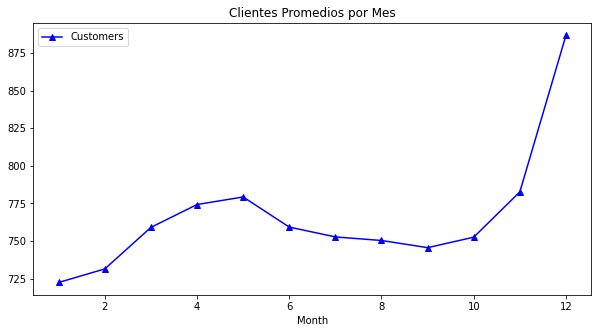

In [30]:
# Echemos un vistazo a las ventas y a los clientes por día del mes.
# El número mínimo de clientes suele rondar el día 24 del mes.
# La mayoría de los clientes y las ventas son alrededor del 30 y el 1 del mes
axis = df.groupby('Month')[['Customers']].mean().plot(figsize=(10,5),marker='^',color='b')
axis.set_title('Clientes Promedios por Mes')
plt.show()

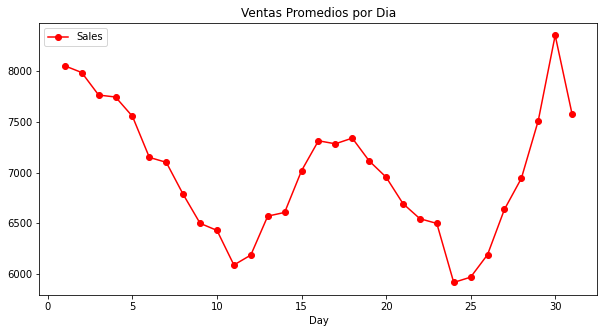

In [31]:
# Hagamos lo mismo para el día de la semana (notemos que 7 = domingo)
axis = df.groupby('Day')[['Sales']].mean().plot(figsize=(10,5),marker='o',color='r')
axis.set_title('Ventas Promedios por Dia')
plt.show()

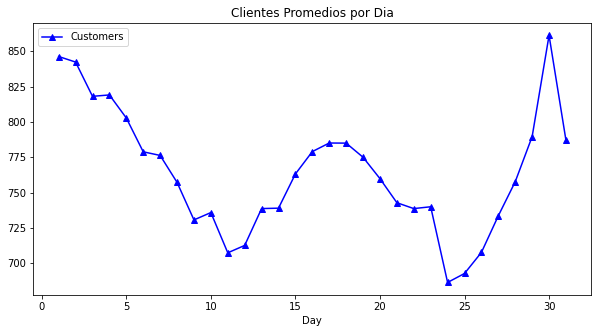

In [32]:
axis = df.groupby('Day')[['Customers']].mean().plot(figsize=(10,5),marker='^',color='b')
axis.set_title('Clientes Promedios por Dia')
plt.show()

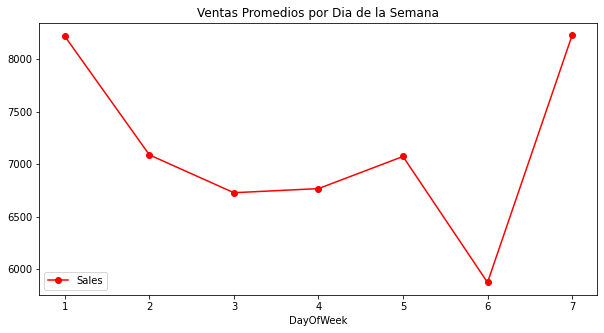

In [33]:
axis = df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize=(10,5),marker='o',color='r')
axis.set_title('Ventas Promedios por Dia de la Semana')
plt.show()

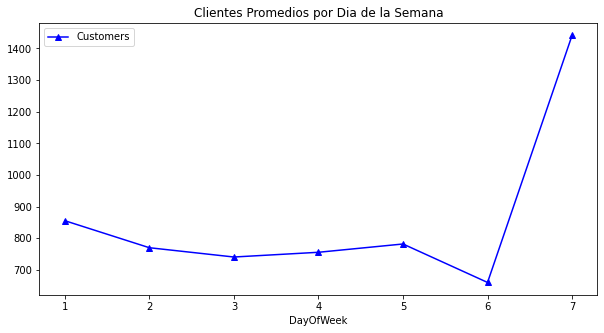

In [34]:
axis = df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize=(10,5),marker='^',color='b')
axis.set_title('Clientes Promedios por Dia de la Semana')
plt.show()

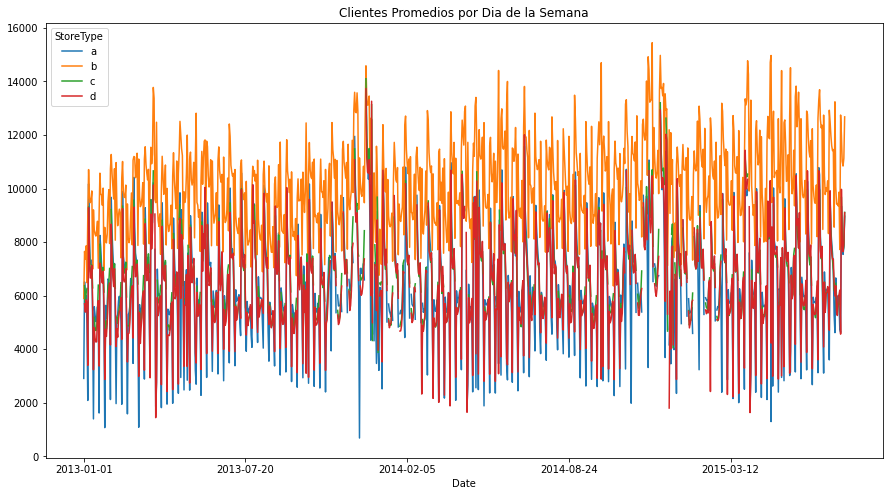

In [35]:
axis = df.groupby(['Date','StoreType']).mean()['Sales'].unstack().plot(figsize=(15,8))
axis.set_title('Clientes Promedios por Dia de la Semana')
plt.show()

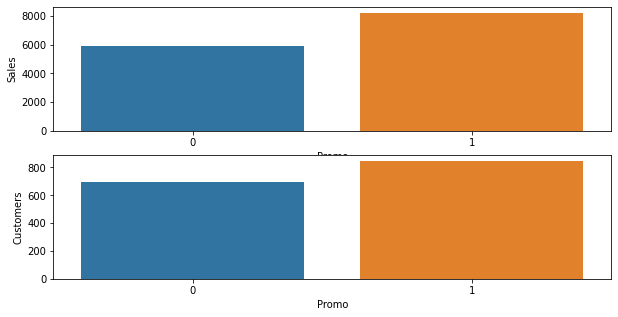

In [36]:
plt.figure(figsize=(10,5))

plt.subplot(211)
sns.barplot(x='Promo',y='Sales',data=df)
plt.subplot(212)
sns.barplot(x='Promo',y='Customers',data=df)

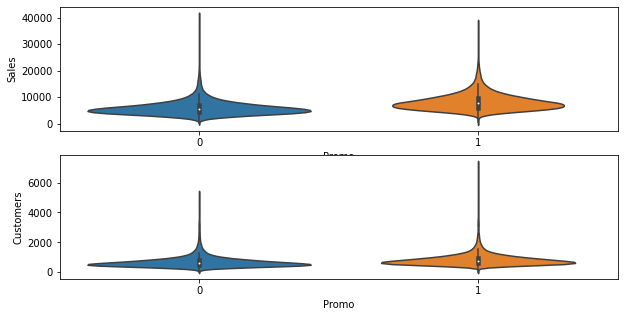

In [37]:
plt.figure(figsize=(10,5))

plt.subplot(211)
sns.violinplot(x='Promo',y='Sales',data=df)
plt.subplot(212)
sns.violinplot(x='Promo',y='Customers',data=df)

# TAREA # 4: ENTENDER LA INTUICIÓN DETRÁS DE FACEBOOK PROPHET

![alt text](https://drive.google.com/uc?id=1zk5cwXQvqci6hOwXoTSU0DY0Dpt1jNF0)

![alt text](https://drive.google.com/uc?id=10HNgyFmM1CG6yzSxpFudunUaHKNV_xBT)

![alt text](https://drive.google.com/uc?id=1BhEzmHYh_HKDWGz4eXP-clF7KAxJ_Od7)

# TAREA # 5: ENTRENAR AL MODELO PARTE A

In [50]:
def sales_prediction(store_id,df,periods):

  df = df[df.Store.isin([store_id])]
  df = df[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})
  df = df.sort_values('ds')

  model = Prophet()
  model.fit(df)
  future = model.make_future_dataframe(periods=periods)
  forecast = model.predict(future)

  figure = model.plot(forecast,xlabel='Fecha',ylabel='Ventas')
  figure2 = model.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


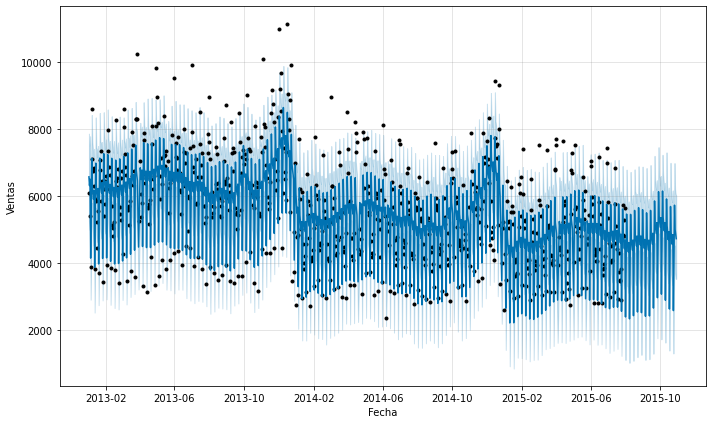

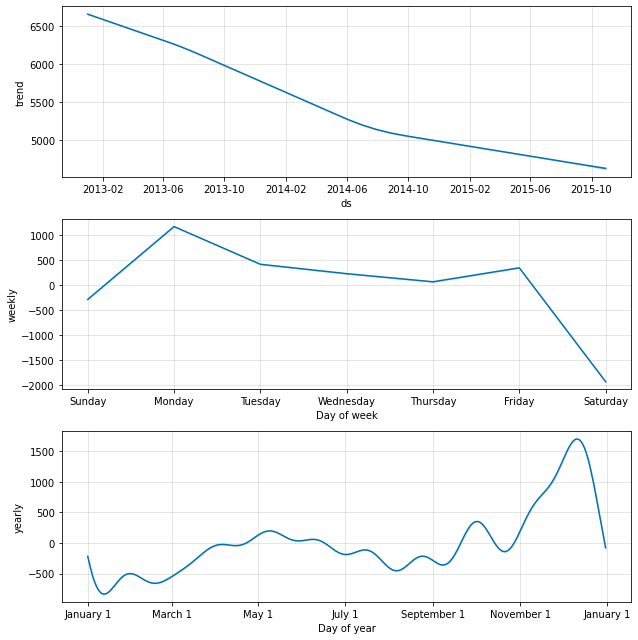

In [51]:
sales_prediction(6,df,90)

# TAREA # 6: ENTRENAR AL MODELO PARTE B

- StateHoliday: indica si el día era festivo o no (a = vacaciones públicas, b = vacaciones de Pascua holiday, c = Navidades, 0 = No era festivo)
- SchoolHoliday: indica si (Store, Date) se ve afectado por el cierre de las escuelas públicas
  






In [52]:
def sales_prediction(store_id,df,holidays,periods):

  df = df[df.Store.isin([store_id])]
  df = df[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})
  df = df.sort_values('ds')

  model = Prophet(holidays=holidays)
  model.fit(df)
  future = model.make_future_dataframe(periods=periods)
  forecast = model.predict(future)

  figure = model.plot(forecast,xlabel='Fecha',ylabel='Ventas')
  figure2 = model.plot_components(forecast)

In [81]:
# Obtener todas las fechas relacionadas con las vacaciones escolares
school_holiday = df[df['SchoolHoliday'].isin([1])].loc[:,'Date'].unique()

In [82]:
# Obtener todas las fechas correspondientes a los festivos estatales
state_holiday  = df[df['StateHoliday'].isin(['a','b','c'])].loc[:,'Date'].unique()

In [85]:
# Concatenamos las vacaciones escolares y los festivos estatales
df_holidays_sc = pd.DataFrame({'ds':pd.to_datetime(school_holiday),'holiday':'school holiday'})
df_state_sc = pd.DataFrame({'ds':pd.to_datetime(state_holiday),'holiday':'state holiday'})

In [87]:
holidays = pd.concat([df_holidays_sc,df_state_sc],axis=0)
holidays

,ds,holiday
0,2015-07-31,school holiday
1,2015-07-30,school holiday
2,2015-07-29,school holiday
3,2015-07-28,school holiday
4,2015-07-27,school holiday
...,...,...
30,2014-11-01,state holiday
31,2013-11-01,state holiday
32,2015-01-06,state holiday
33,2014-01-06,state holiday


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


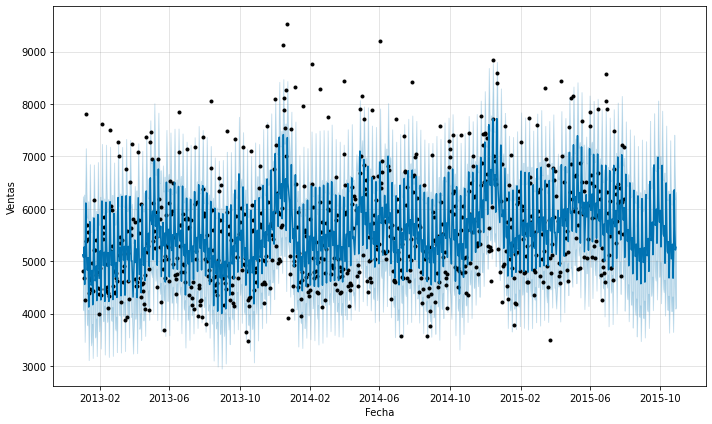

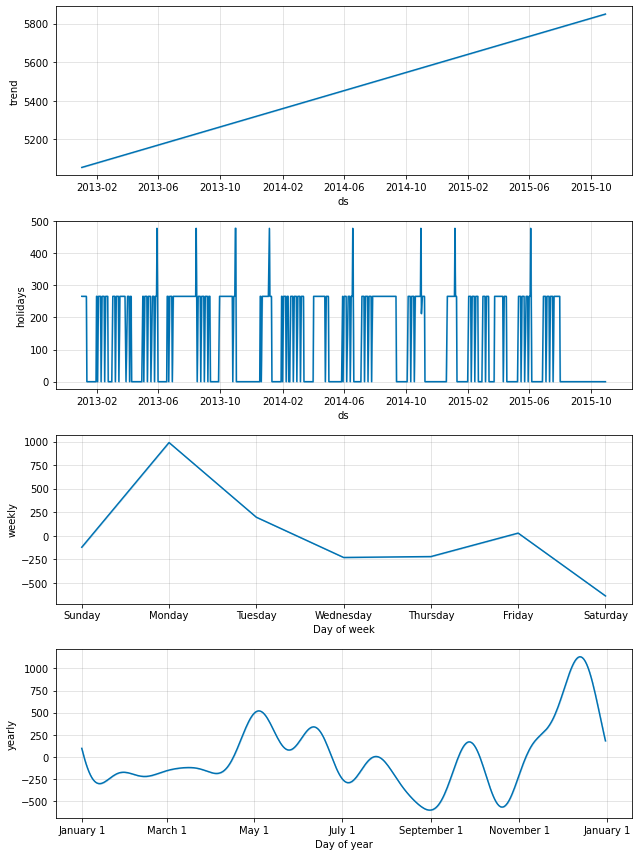

In [89]:
# Hagamos predicciones usando días festivos para una tienda específica
sales_prediction(10,df,holidays,90)

# BUEN TRABAJO!!!